In [2]:
import tensorflow as tf
import os
import PIL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers,datasets
import cv2

In [6]:
!pip install --upgrade tensorflow_hub

   ---------------------------------------- 0.0/85.4 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.4 kB ? eta -:--:--
   -------------- ------------------------- 30.7/85.4 kB 262.6 kB/s eta 0:00:01
   -------------- ------------------------- 30.7/85.4 kB 262.6 kB/s eta 0:00:01
   ---------------------------- ----------- 61.4/85.4 kB 328.2 kB/s eta 0:00:01
   ---------------------------------------- 85.4/85.4 kB 370.3 kB/s eta 0:00:00


In [7]:
import tensorflow_hub as hub

In [9]:
IMAGE_SHAPE=(224,224)
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [11]:
dataset_url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir=keras.utils.get_file("flower_photos",origin=dataset_url,cache_dir=".",untar=True)

228813984/228813984 [==============================] - 72s 0us/step


In [12]:
import pathlib
data_dir=pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [13]:
flower_dataset={
    "roses":list(data_dir.glob("roses/*")),
    "tulips":list(data_dir.glob("tulips/*")),
    "sunflowers":list(data_dir.glob("sunflowers/*")),
    "daisy":list(data_dir.glob("daisy/*")),
    "dandelion":list(data_dir.glob("dandelion/*"))
}

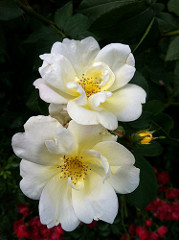

In [15]:
PIL.Image.open(str(flower_dataset["roses"][0]))

In [16]:
flower_names={"roses":0,"tulips":1,"sunflowers":2,"daisy":3,"dandelion":4}

In [19]:
x=[]
y=[]
for flower_name,images in flower_dataset.items():
    for img in images:
        img=cv2.imread(str(img))
        resized=cv2.resize(img,(IMAGE_SHAPE))
        x.append(resized)
        y.append(flower_names[flower_name])

In [21]:
x=np.array(x)
y=np.array(y)
x[0].shape

(224, 224, 3)

In [23]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0)

In [24]:
x_train_scaled=x_train/255
x_test_scaled=x_test/255

In [27]:
y_preds=classifier.predict(x_test)

29/29 [==============================] - 9s 292ms/step


In [28]:
y_preds_final=[np.argmax(i) for i in y_preds]

In [29]:
y_preds_final[0]

795

In [31]:
with open("ImageNetLabels.txt") as f:
    img_labels=f.readlines()

In [33]:
img_labels[795]

'shower curtain\n'

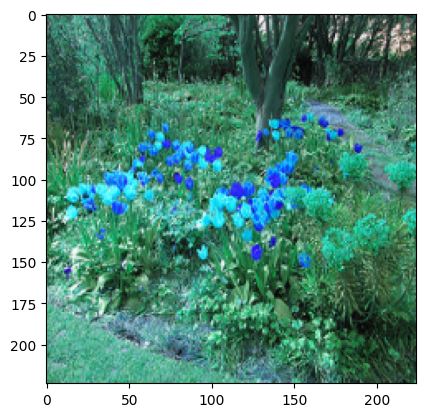

In [34]:
plt.imshow(x_test[0])

In [35]:
train_preds=classifier.predict(x_train)

86/86 [==============================] - 26s 304ms/step


In [36]:
train_preds_final=[np.argmax(i) for i in train_preds]

In [37]:
train_preds_final[1]

550

In [39]:
img_labels[549]

'entertainment center\n'

In [40]:
## Now take pre-trained model and re train it using flower images

In [41]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [42]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [43]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(x_train_scaled, y_train, epochs=5)

Epoch 1/5



86/86 [==============================] - 32s 312ms/step - loss: 0.8332 - accuracy: 0.6820
Epoch 2/5
86/86 [==============================] - 22s 257ms/step - loss: 0.4224 - accuracy: 0.8525
Epoch 3/5
86/86 [==============================] - 23s 273ms/step - loss: 0.3333 - accuracy: 0.8910
Epoch 4/5
86/86 [==============================] - 22s 254ms/step - loss: 0.2761 - accuracy: 0.9142
Epoch 5/5
86/86 [==============================] - 21s 248ms/step - loss: 0.2442 - accuracy: 0.9241


In [44]:
y_preds=model.predict(x_test)

29/29 [==============================] - 8s 255ms/step


In [45]:
y_preds_final=[np.argmax(i) for i in y_preds]

In [46]:
y_preds_final[:5]

[4, 3, 3, 3, 3]

In [47]:
y_test[:5]

array([1, 0, 2, 4, 2])

In [ ]:
model.evaluate(x_test,y_test)

10/29 [=========>....................] - ETA: 5s - loss: 2.9647 - accuracy: 0.2156